In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

file_path = 'EN\subtask-2-annotations.txt'
df = pd.read_csv(file_path, sep="\t", header=None, names=["Document_ID", "High_Level_Narratives", "Sub_Narratives"])

df = df.groupby("Document_ID").agg({
    "High_Level_Narratives": lambda x: list(set(";".join(x).split(";"))),
    "Sub_Narratives": lambda x: list(set(";".join(x).split(";")))
}).reset_index()

df.rename(columns={
    "High_Level_Narratives": "High_Level_Narratives_List",
    "Sub_Narratives": "Sub_Narratives_List"
}, inplace=True)

df

,Document_ID,High_Level_Narratives_List,Sub_Narratives_List
0,EN_CC_100000.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Oth...
1,EN_CC_100002.txt,[CC: Hidden plots by secret schemes of powerfu...,[CC: Criticism of institutions and authorities...
2,EN_CC_100003.txt,[CC: Criticism of institutions and authorities...,[CC: Criticism of institutions and authorities...
3,EN_CC_100004.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Ren...
4,EN_CC_100005.txt,[CC: Criticism of climate movement],[CC: Criticism of climate movement: Climate mo...
...,...,...,...
394,EN_UA_DEV_100028.txt,[URW: Negative Consequences for the West],[URW: Negative Consequences for the West: Sanc...
395,EN_UA_DEV_216.txt,"[URW: Discrediting the West, Diplomacy, URW: N...","[URW: Discrediting the West, Diplomacy: The EU..."
396,EN_UA_DEV_23.txt,"[URW: Amplifying war-related fears, URW: Prais...",[URW: Praise of Russia: Praise of Russian mili...
397,EN_UA_DEV_24.txt,"[URW: Discrediting the West, Diplomacy, URW: N...",[URW: Negative Consequences for the West: Sanc...


In [15]:
# Add a Binary Classification Column
def classify_binary(narratives):
    if any(narrative.startswith(('URW', 'CC')) for narrative in narratives):
        return 1  # Non-Other
    return 0  # Other

# Apply the classification to High_Level_Narratives_List
df['Binary_Label'] = df['High_Level_Narratives_List'].apply(classify_binary)

# Display the updated DataFrame
df.value_counts('Binary_Label')


Binary_Label
1    230
0    169
dtype: int64

In [16]:
df.head()

,Document_ID,High_Level_Narratives_List,Sub_Narratives_List,Binary_Label
0,EN_CC_100000.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Oth...,1
1,EN_CC_100002.txt,[CC: Hidden plots by secret schemes of powerfu...,[CC: Criticism of institutions and authorities...,1
2,EN_CC_100003.txt,[CC: Criticism of institutions and authorities...,[CC: Criticism of institutions and authorities...,1
3,EN_CC_100004.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Ren...,1
4,EN_CC_100005.txt,[CC: Criticism of climate movement],[CC: Criticism of climate movement: Climate mo...,1


In [17]:
import os

# Path to the raw-documents folder
documents_folder = r'EN\raw-documents'

# Function to read all document texts and map to their IDs
def load_documents(folder_path):
    documents = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):  # Ensure only text files are read
            doc_id = filename  # Extract Document_ID from filename
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as file:
                documents[doc_id] = file.read().strip()
    return documents

# Load document texts into a dictionary
document_texts = load_documents(documents_folder)

# Map document texts to the DataFrame
df['Text'] = df['Document_ID'].map(document_texts)

# Check if all documents are successfully mapped
print(f"Number of missing documents: {df['Text'].isnull().sum()}")
df.head()


Number of missing documents: 0


,Document_ID,High_Level_Narratives_List,Sub_Narratives_List,Binary_Label,Text
0,EN_CC_100000.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Oth...,1,Pentagon plans to serve LAB-GROWN MEAT to troo...
1,EN_CC_100002.txt,[CC: Hidden plots by secret schemes of powerfu...,[CC: Criticism of institutions and authorities...,1,Oxford Residents Mount Resistance Against the ...
2,EN_CC_100003.txt,[CC: Criticism of institutions and authorities...,[CC: Criticism of institutions and authorities...,1,"Fonda Heads To Canada For Oil Sands Protest, M..."
3,EN_CC_100004.txt,"[CC: Controversy about green technologies, CC:...",[CC: Controversy about green technologies: Ren...,1,A Tesla Owner Just Exposed A Sick Secret About...
4,EN_CC_100005.txt,[CC: Criticism of climate movement],[CC: Criticism of climate movement: Climate mo...,1,Climate Crazies Fail in Attempt to Vandalize A...


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Get predicted class
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }
    
    



In [19]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Load RoBERTa tokenizer and model
MODEL_NAME = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)  # Binary classification


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
from datasets import Dataset

# Convert DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_pandas(df[['Text', 'Binary_Label']])

# Tokenize the text data
def tokenize_function(examples):
    return tokenizer(examples['Text'], padding="max_length", truncation=True)

tokenized_datasets = hf_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

In [21]:
from sklearn.model_selection import train_test_split

# Split into train and test sets
train_test_split = tokenized_datasets.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
test_dataset = train_test_split['test']


In [22]:
print(f"Number of training examples: {len(train_dataset)}")
print(f"Number of testing examples: {len(test_dataset)}")

Number of training examples: 319
Number of testing examples: 80


In [24]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Assuming your labels are in a column called 'Binary_Label' in a DataFrame
class_labels = df['Binary_Label'].values
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(class_labels), 
    y=class_labels
)

# Convert to a PyTorch tensor
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)


Class weights: tensor([1.1805, 0.8674])


In [25]:
from torch.nn import CrossEntropyLoss

# Update the forward pass to include weighted loss
class WeightedRobertaModel(torch.nn.Module):
    def __init__(self, model, class_weights):
        super(WeightedRobertaModel, self).__init__()
        self.model = model
        self.class_weights = class_weights
        self.loss_fn = CrossEntropyLoss(weight=self.class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)
        return {"loss": loss, "logits": logits} if labels is not None else {"logits": logits}


In [26]:
weighted_model = WeightedRobertaModel(model, class_weights)


In [27]:
# from transformers import TrainingArguments

# training_args = TrainingArguments(
#     output_dir="./results",  # Directory to save results
#     evaluation_strategy="epoch",  # Evaluate at the end of each epoch
#     save_strategy="epoch",  # Save at the end of each epoch
#     learning_rate=1e-5,  # Fine-tuning learning rate
#     per_device_train_batch_size=12,  # Batch size per GPU
#     per_device_eval_batch_size=16,
#     num_train_epochs=10,  # Number of epochs
#     # weight_decay=0.01,  # L2 regularization
#     logging_dir="./logs",  # Directory for logs
#     logging_steps=10,
#     load_best_model_at_end=True  # Load the best model after training
# )



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',                    # Directory to store checkpoints and final model
    num_train_epochs=10,                       # Total number of training epochs
    learning_rate=2e-5,  # Fine-tuning learning rate
    per_device_train_batch_size=10,            # Batch size per device during training
    per_device_eval_batch_size=10,             # Batch size for evaluation
    evaluation_strategy='epoch',               # Evaluate at the end of each epoch
    save_strategy='epoch',                     # Save model at the end of each epoch
    load_best_model_at_end=True,               # Load the best model at the end of training
    metric_for_best_model='f1',                # Use F1 score to evaluate the best model
    greater_is_better=True,                    # Higher F1 is better
    logging_dir='./logs',                      # Directory for storing logs
    logging_steps=100,                         # Log every 100 steps
    save_total_limit=3,                        # Limit the total amount of checkpoints
    seed=42,                                   # Seed for reproducibility
)



c:\Users\makan\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [28]:
# Rename the Binary_Label column to labels
train_dataset = train_dataset.rename_column("Binary_Label", "labels")
test_dataset = test_dataset.rename_column("Binary_Label", "labels")
test_dataset


Dataset({
    features: ['Text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 80
})

In [29]:
from transformers import Trainer

# Define Trainer
trainer = Trainer(
    model=  weighted_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


# Train the model
trainer.train()


  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6743009090423584, 'eval_accuracy': 0.6625, 'eval_precision': 0.6140350877192983, 'eval_recall': 0.875, 'eval_f1': 0.7216494845360825, 'eval_runtime': 1.4223, 'eval_samples_per_second': 56.246, 'eval_steps_per_second': 5.625, 'epoch': 1.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5474344491958618, 'eval_accuracy': 0.75, 'eval_precision': 0.6851851851851852, 'eval_recall': 0.925, 'eval_f1': 0.7872340425531915, 'eval_runtime': 1.4277, 'eval_samples_per_second': 56.033, 'eval_steps_per_second': 5.603, 'epoch': 2.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5304887294769287, 'eval_accuracy': 0.7, 'eval_precision': 0.8333333333333334, 'eval_recall': 0.5, 'eval_f1': 0.625, 'eval_runtime': 1.4425, 'eval_samples_per_second': 55.459, 'eval_steps_per_second': 5.546, 'epoch': 3.0}
{'loss': 0.5772, 'grad_norm': 12.742156028747559, 'learning_rate': 6.875e-06, 'epoch': 3.12}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.547718346118927, 'eval_accuracy': 0.75, 'eval_precision': 0.717391304347826, 'eval_recall': 0.825, 'eval_f1': 0.7674418604651163, 'eval_runtime': 1.4445, 'eval_samples_per_second': 55.384, 'eval_steps_per_second': 5.538, 'epoch': 4.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.6109122037887573, 'eval_accuracy': 0.7625, 'eval_precision': 0.723404255319149, 'eval_recall': 0.85, 'eval_f1': 0.7816091954022989, 'eval_runtime': 1.4534, 'eval_samples_per_second': 55.043, 'eval_steps_per_second': 5.504, 'epoch': 5.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.795811653137207, 'eval_accuracy': 0.7375, 'eval_precision': 0.7435897435897436, 'eval_recall': 0.725, 'eval_f1': 0.7341772151898734, 'eval_runtime': 1.442, 'eval_samples_per_second': 55.478, 'eval_steps_per_second': 5.548, 'epoch': 6.0}
{'loss': 0.2788, 'grad_norm': 8.475090026855469, 'learning_rate': 3.7500000000000005e-06, 'epoch': 6.25}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.9868605732917786, 'eval_accuracy': 0.7125, 'eval_precision': 0.6976744186046512, 'eval_recall': 0.75, 'eval_f1': 0.7228915662650602, 'eval_runtime': 1.4493, 'eval_samples_per_second': 55.2, 'eval_steps_per_second': 5.52, 'epoch': 7.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0247923135757446, 'eval_accuracy': 0.7375, 'eval_precision': 0.6938775510204082, 'eval_recall': 0.85, 'eval_f1': 0.7640449438202247, 'eval_runtime': 1.4421, 'eval_samples_per_second': 55.475, 'eval_steps_per_second': 5.547, 'epoch': 8.0}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.0734596252441406, 'eval_accuracy': 0.75, 'eval_precision': 0.7083333333333334, 'eval_recall': 0.85, 'eval_f1': 0.7727272727272727, 'eval_runtime': 1.4439, 'eval_samples_per_second': 55.406, 'eval_steps_per_second': 5.541, 'epoch': 9.0}
{'loss': 0.1345, 'grad_norm': 4.904441833496094, 'learning_rate': 6.25e-07, 'epoch': 9.38}


  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 1.1277389526367188, 'eval_accuracy': 0.75, 'eval_precision': 0.717391304347826, 'eval_recall': 0.825, 'eval_f1': 0.7674418604651163, 'eval_runtime': 1.4231, 'eval_samples_per_second': 56.216, 'eval_steps_per_second': 5.622, 'epoch': 10.0}
{'train_runtime': 212.3352, 'train_samples_per_second': 15.023, 'train_steps_per_second': 1.507, 'train_loss': 0.3229636371135712, 'epoch': 10.0}


TrainOutput(global_step=320, training_loss=0.3229636371135712, metrics={'train_runtime': 212.3352, 'train_samples_per_second': 15.023, 'train_steps_per_second': 1.507, 'total_flos': 0.0, 'train_loss': 0.3229636371135712, 'epoch': 10.0})

In [37]:
results = trainer.evaluate(eval_dataset=test_dataset)
print(results)



  0%|          | 0/8 [00:00<?, ?it/s]

{'eval_loss': 0.5474344491958618, 'eval_accuracy': 0.75, 'eval_precision': 0.6851851851851852, 'eval_recall': 0.925, 'eval_f1': 0.7872340425531915, 'eval_runtime': 1.7091, 'eval_samples_per_second': 46.809, 'eval_steps_per_second': 4.681, 'epoch': 10.0}


In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(pred):
    logits, labels = pred
    # Convert logits to probabilities
    probabilities = torch.softmax(torch.tensor(logits), dim=-1)[:, 1]
    # Apply custom threshold
    threshold = 0.7  # Adjust this value to tune precision
    predictions = (probabilities > threshold).int().numpy()
    # Calculate metrics
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
    }


  0%|          | 0/8 [00:00<?, ?it/s]

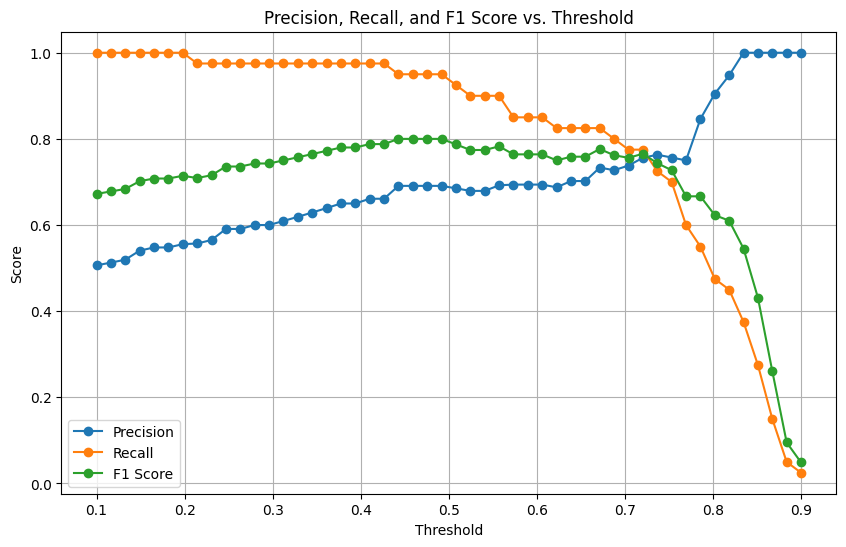

In [36]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to evaluate metrics across thresholds
def evaluate_with_thresholds(predictions_output, thresholds):
    logits = predictions_output.predictions  # Extract logits
    labels = predictions_output.label_ids  # Extract true labels
    probabilities = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy()  # Convert logits to probabilities
    precisions, recalls, f1_scores = [], [], []
    for threshold in thresholds:
        preds = (probabilities > threshold).astype(int)
        precisions.append(precision_score(labels, preds))
        recalls.append(recall_score(labels, preds))
        f1_scores.append(f1_score(labels, preds))
    return precisions, recalls, f1_scores

# Generate thresholds to test
thresholds = np.linspace(0.1, 0.9, 50)

# Perform predictions
predictions_output = trainer.predict(test_dataset)

# Evaluate metrics across thresholds
precisions, recalls, f1_scores = evaluate_with_thresholds(predictions_output, thresholds)

# Plot Precision, Recall, and F1 Score vs. Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label="Precision", marker="o")
plt.plot(thresholds, recalls, label="Recall", marker="o")
plt.plot(thresholds, f1_scores, label="F1 Score", marker="o")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs. Threshold")
plt.legend()
plt.grid(True)
plt.show()
